# Drift Detection in CapyMOA

In this tutorial, we show how to conduct drift detection using CapyMOA.

* Usage example of several detectors.
* Example using ADWIN.
* Evaluating detectors based on known drift locations.
* Multivariate drift detection using ABCD.

---

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last update on 28/11/2025**

In [1]:
import numpy as np
import pandas as pd

import capymoa.drift.detectors as detectors

## 1. Basic example

* Creating dummy data

In [2]:
data_stream = np.random.randint(2, size=2000)
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

* Basic drift detection example

In [3]:
all_detectors = detectors.__all__

n_detections = {k: 0 for k in all_detectors}
for detector_name in all_detectors:
    if detector_name == "STUDD":
        continue

    detector = getattr(detectors, detector_name)()

    for i in range(2000):
        detector.add_element(float(data_stream[i]))
        if detector.detected_change():
            n_detections[detector_name] += 1

print(pd.Series(n_detections))

ABCD                        1
ADWIN                       1
CUSUM                       2
DDM                         1
EWMAChart                   1
GeometricMovingAverage      1
HDDMAverage               135
HDDMWeighted               88
OPTWIN                      1
PageHinkley                 2
RDDM                        1
SEED                        2
STEPD                       1
STUDD                       0
dtype: int64


## 2. Example using ADWIN

In [4]:
# detector = ADWIN(delta=0.001)

for i in range(2000):
    detector.add_element(data_stream[i])
    if detector.detected_change():
        print(
            "Change detected in data: " + str(data_stream[i]) + " - at index: " + str(i)
        )

In [5]:
# Detection indices
detector.detection_index

[1000]

In [6]:
# Warning indices
detector.warning_index

[92,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 638,
 639,
 640,
 641,
 644,
 726,
 729,
 730,
 731]

In [7]:
# Instance counter
detector.idx

4000

## 3. Evaluating drift detectors

Assuming the drift locations are known, you can evaluate detectors using **EvaluateDetector** class.

This class takes a parameter called **max_delay**, which is the maximum number of instances for which we consider a detector to have detected a change. After **max_delay** instances, we assume that the change is obvious and has been missed by the detector.

In [8]:
from capymoa.drift.eval_detector import EvaluateDriftDetector

drift_eval = EvaluateDriftDetector(max_delay=200)

The EvaluateDetector class takes two arguments for evaluating detectors:
- The locations of the drift
- The locations of the detections

In [9]:
trues = np.array([1000])
preds = detector.detection_index

drift_eval.calc_performance(trues, preds, tot_n_instances=detector.idx)

DriftDetectionMetrics(fp=0, tp=1, fn=0, precision=1.0, recall=1.0, episode_recall=1.0, f1=1.0, mdt=np.float64(0.0), far=0.0, ar=0.25, n_episodes=1, n_alarms=1)

## 4. Multivariate drift detection

In [10]:
from capymoa.drift.detectors import ABCD
from capymoa.datasets import ElectricityTiny

detector = ABCD()

## Opening a file as a stream
stream = ElectricityTiny()

In [11]:
i = 0
loss_values = []
while stream.has_more_instances and i < 5000:
    i += 1
    instance = stream.next_instance()
    detector.add_element(instance)
    loss_values.append(detector.loss())
    if detector.detected_change():
        print("Change detected at index: " + str(i))

Change detected at index: 2776


In [12]:
detector = ABCD(model_id="pca")

## Opening a file as a stream
stream_change = np.hstack(
    [np.random.uniform(0, 0.5, 3000), np.random.uniform(0.5, 1.0, 3000)]
)
stream_nochange = np.random.uniform(0, 1.0, len(stream_change))
stream = np.vstack([stream_change, stream_nochange]).T
print(f"A {stream.shape[-1]}-dimensional stream")

A 2-dimensional stream


In [13]:
i = 0
loss_values = []
while i < len(stream):
    instance = stream[i]
    i += 1
    detector.add_element(instance)
    loss_values.append(detector.loss())
    if detector.detected_change():
        print("Change detected at index: " + str(i))

Change detected at index: 3060


Text(0, 0.5, 'Reconstruction loss')

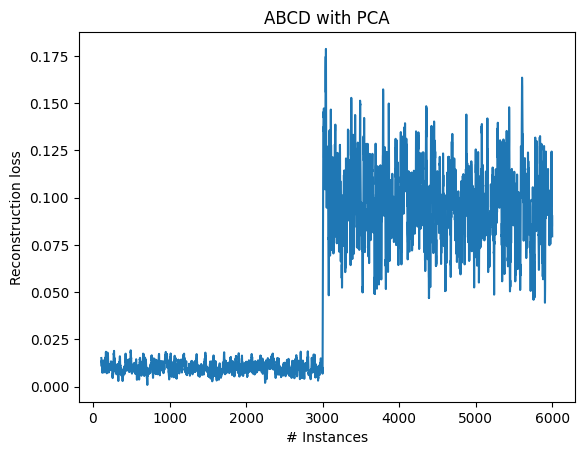

In [14]:
import matplotlib.pyplot as plt

plt.plot(pd.Series(loss_values).rolling(10).mean())
plt.title("ABCD with PCA")
plt.xlabel("# Instances")
plt.ylabel("Reconstruction loss")

We see that a value of 1 as maximum reconstruction error is very conservative. By decreasing the `maximum_absolute_value` parameter, we can make change detection faster as it makes the applied statistical test more sensitive.

In [15]:
detector = ABCD(model_id="pca", maximum_absolute_value=0.3)

i = 0
loss_values = []
while i < len(stream):
    instance = stream[i]
    i += 1
    detector.add_element(instance)
    loss_values.append(detector.loss())
    if detector.detected_change():
        print("Change detected at index: " + str(i))

Change detected at index: 3023
